# Import Libraries

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score

sns.set_palette(palette='Set1', n_colors=5)

# Import And Visualize Data

In [43]:
df = pd.read_csv('data/train.csv')

In [3]:
display(df.head())

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Understand Missing Data

In [5]:
missing_data_map = {
    'Column Name': [],
    'Missing Data Per Cent': []
}

for c in df.columns.values:
    col_series = df.loc[:, c]
    missing_data = col_series.isna().sum() / col_series.size
    missing_data_map['Column Name'].append(c)
    missing_data_map['Missing Data Per Cent'].append(round(missing_data * 100, 2))

display(pd.DataFrame(missing_data_map))

,Column Name,Missing Data Per Cent
0,PassengerId,0.00
1,HomePlanet,2.31
2,CryoSleep,2.50
3,Cabin,2.29
4,Destination,2.09
5,Age,2.06
6,VIP,2.34
7,RoomService,2.08
8,FoodCourt,2.11
9,ShoppingMall,2.39


Let's see what happens if we decide to drop the missing values:

In [7]:
display(df.shape)

df_2 = df.dropna()

display(df_2.shape)

(8693, 14)

(6606, 14)

Roughly 2000 rows will be lost, which is 25% of the data. So no data will be dropped.

Some of the columns such as `Cabin` are categorical and will be handled as such.

Numberical columns such as `RoomService` will be filled with `0` for the first analysis - the volume of missing data is very low, so imputing might not be required.

Let's understand how many of the passengers that were not in cryo sleep used the facilities (based on the money they spent there). It should be noted that if you are in cryo sleep, you are frozen - you cannot go around and spend money.

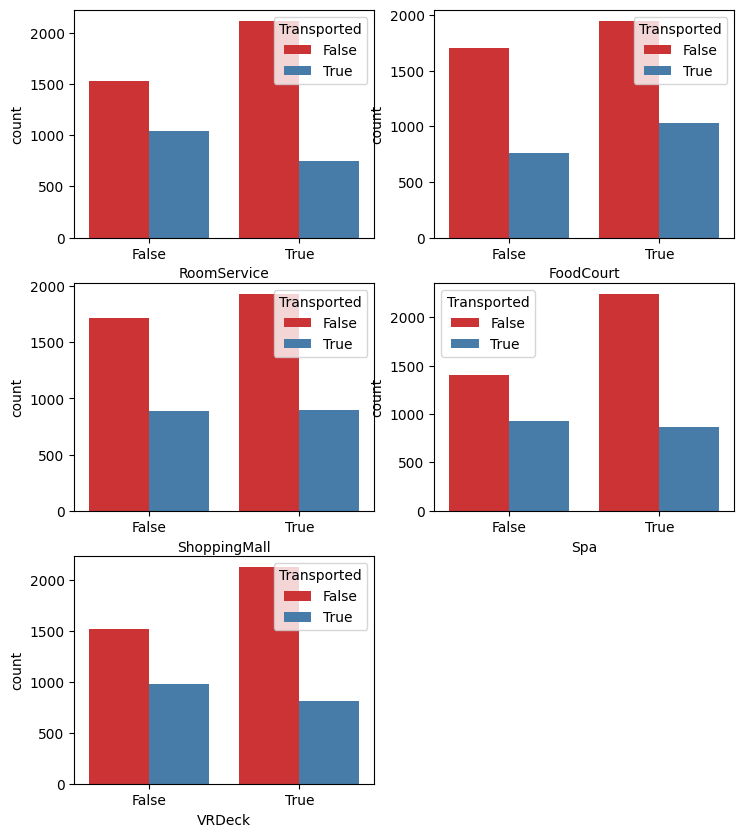

In [148]:
facilities_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

df_3 = df.loc[df['CryoSleep'] == False]

column_serieses = {}
for c in facilities_columns:
    column_serieses[c] = df_3[c] > 0

column_serieses['Transported'] = df_3['Transported']

facilities_df = pd.DataFrame(column_serieses)

fig = plt.figure(figsize=(6, 4))
for i, c in enumerate(facilities_columns):
    ax = fig.add_subplot(len(facilities_columns), 2, i + 1)
    plt.subplots_adjust(bottom=-2.5, right=0.8, top=0.8, left=-0.3)
    sns.countplot(facilities_df, x=c, hue='Transported', ax=ax)

It appears that from those that did not use the facilities, a larger portion were transported.

From those that used the facilities, most were not trasnported.

This suggests that there is a relation to facility usage (location on the ship) and the transportation likelihood.

Now let's check if the VIP status also plays a role in the likelihood of being trasnported.

<Axes: xlabel='VIP', ylabel='count'>

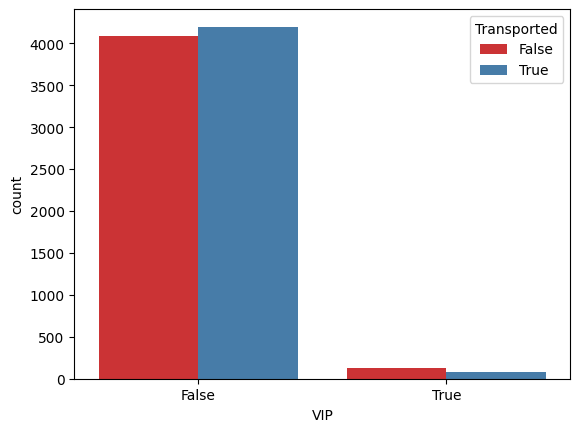

In [142]:
sns.countplot(df, x='VIP', hue='Transported')

There is no weight for the `VIP` column in terms of likelihood of bein transported (nearly 50/50), which is why this column will be ignored.

Now let's see if the `HomePlanet` and `Destination` columns have any relation to the likelihood of being transported.

<Axes: xlabel='HomePlanet', ylabel='count'>

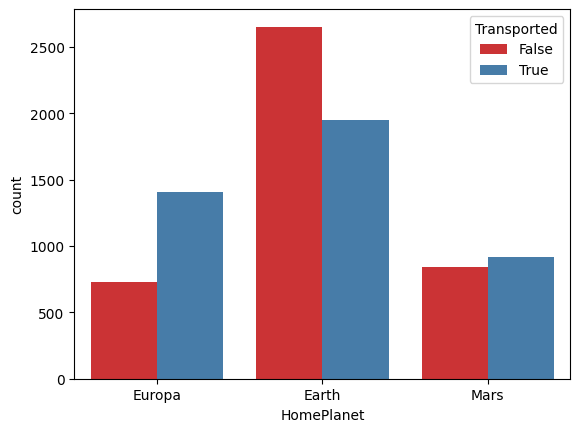

In [144]:
sns.countplot(df, x='HomePlanet', hue='Transported')

It appears that there is some relation for the `HomePlanet` column, but for __Mars__ it is a 50/50 split. Still, the `HomePlanet` column will be kept.

<Axes: xlabel='Destination', ylabel='count'>

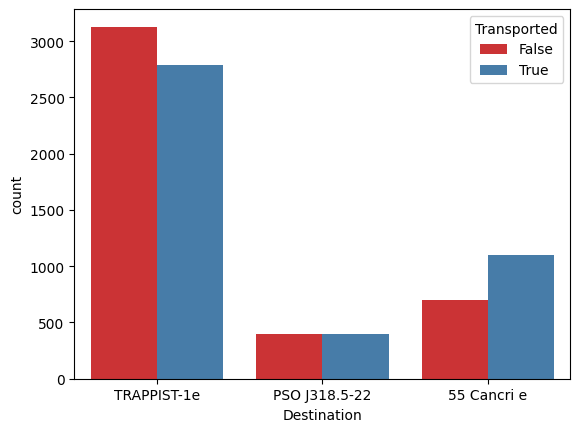

In [145]:
sns.countplot(df, x='Destination', hue='Transported')

For the `Desitnation` column, it seems that there is little variance in the values. As scuh, this column will be removed during analysis.

The last column to check is `CryoSleep`:

<Axes: xlabel='CryoSleep', ylabel='count'>

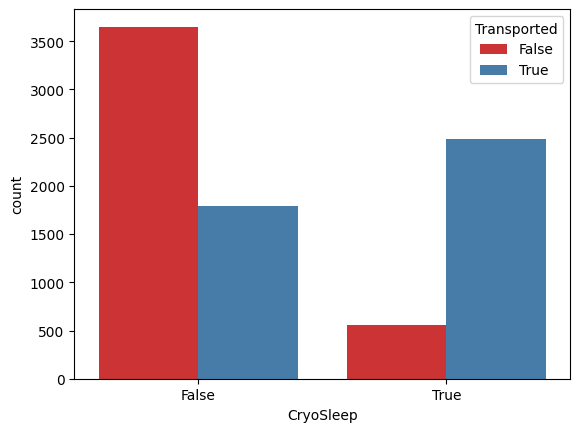

In [146]:
sns.countplot(df, x='CryoSleep', hue='Transported')

There is significance weight if the passenger was in `CryoSleep` or not - those in cryosleep seem to have the heighest likelihood of bein trasnported.

Now let's go and fill in the missing values for the `Age` column and the facilities columns.

In [96]:
df_prep = df.copy()
df_prep[facilities_columns] = df_prep[facilities_columns].fillna(0, axis=0)
df_prep['Age'] = df['Age'].fillna(-1, axis=0)

When handling the missing cabin data, we first need to fill all missing cabin data with `NaN/-1/NaN` which denotes that the deck, number and side are missing. This then allows further processing of the data and will also allow for the data to be encoded later on.

In [97]:
cabin_split = df['Cabin'].fillna('Unknown/-1/Unknown').str.split('/')
cabin_column_arrays = np.array(cabin_split.to_numpy().T.tolist()).transpose()
df_prep['Deck_Letter'] = cabin_column_arrays[0]
df_prep['Deck_Number'] = cabin_column_arrays[1].astype('int')
df_prep['Deck_Side'] = cabin_column_arrays[2]

display(df_prep)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck_Letter,Deck_Number,Deck_Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,A,98,P
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,G,1499,S
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,G,1500,S
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,E,608,S


In [98]:
passenger_split = df['PassengerId'].fillna('-1_-1').str.split('_')
passenger_split_arrays = np.array(passenger_split.to_numpy().T.tolist()).transpose()
df_prep['Passenger_Group'] = passenger_split_arrays[0].astype(int)
df_prep['Passenger_Group_Number'] = passenger_split_arrays[1].astype(int)

In [149]:
df_prep_2 = df_prep.drop(columns=['PassengerId', 'Cabin', 'Name', 'Destination', 'VIP'])

display(df_prep_2)

,HomePlanet,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck_Letter,Deck_Number,Deck_Side,Passenger_Group,Passenger_Group_Number
0,Europa,False,39.0,0.0,0.0,0.0,0.0,0.0,False,B,0,P,1,1
1,Earth,False,24.0,109.0,9.0,25.0,549.0,44.0,True,F,0,S,2,1
2,Europa,False,58.0,43.0,3576.0,0.0,6715.0,49.0,False,A,0,S,3,1
3,Europa,False,33.0,0.0,1283.0,371.0,3329.0,193.0,False,A,0,S,3,2
4,Earth,False,16.0,303.0,70.0,151.0,565.0,2.0,True,F,1,S,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,41.0,0.0,6819.0,0.0,1643.0,74.0,False,A,98,P,9276,1
8689,Earth,True,18.0,0.0,0.0,0.0,0.0,0.0,False,G,1499,S,9278,1
8690,Earth,False,26.0,0.0,0.0,1872.0,1.0,0.0,True,G,1500,S,9279,1
8691,Europa,False,32.0,0.0,1049.0,0.0,353.0,3235.0,False,E,608,S,9280,1


<Axes: xlabel='Total_Expenses', ylabel='count'>

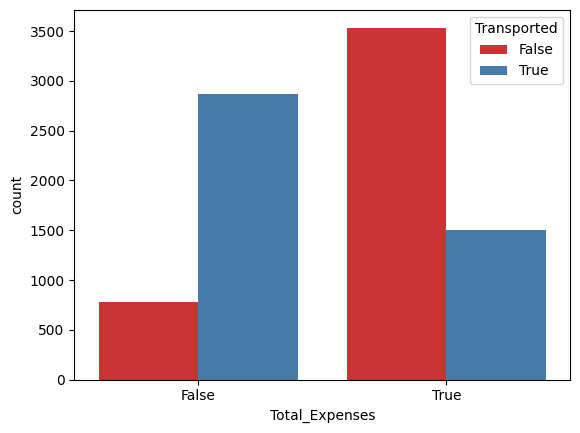

In [157]:
df_prep_2['Total_Expenses'] = df[facilities_columns].sum(axis=1)

df_4 = df_prep_2.drop(columns='Total_Expenses')
df_4['Total_Expenses'] = df_prep_2['Total_Expenses'] > 0

sns.countplot(df_4, x='Total_Expenses', hue='Transported')

The total number of expenses appears to be an indicator of likelihood of being trasnported as well. It will be added as well. At the end, we will attempt to understand if it continues to carry weight.

In [151]:
categorical_columns = ['HomePlanet', 'CryoSleep', 'Deck_Letter', 'Deck_Side']
df_encoded = df_prep_2.drop(columns=categorical_columns)

for col in categorical_columns:
    encoder = OneHotEncoder(handle_unknown='error')
    pclass_encoded = encoder.fit_transform(df_prep_2[[col]])
    # The results are transposed, because the original result has 891 rows with 3 elements per class.
    # However, we want to have 3 rows with all elements per class, where each row represents each class.
    pclass_encoded = pclass_encoded.transpose()

    for i, cat in enumerate(encoder.categories_[0]):
        df_encoded['%s_%s' % (col, cat)] = pclass_encoded.getrow(i).toarray()[0].astype('int')

display(df_encoded)
display(df_encoded.info())

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck_Number,Passenger_Group,Passenger_Group_Number,...,Deck_Letter_C,Deck_Letter_D,Deck_Letter_E,Deck_Letter_F,Deck_Letter_G,Deck_Letter_T,Deck_Letter_Unknown,Deck_Side_P,Deck_Side_S,Deck_Side_Unknown
0,39.0,0.0,0.0,0.0,0.0,0.0,False,0,1,1,...,0,0,0,0,0,0,0,1,0,0
1,24.0,109.0,9.0,25.0,549.0,44.0,True,0,2,1,...,0,0,0,1,0,0,0,0,1,0
2,58.0,43.0,3576.0,0.0,6715.0,49.0,False,0,3,1,...,0,0,0,0,0,0,0,0,1,0
3,33.0,0.0,1283.0,371.0,3329.0,193.0,False,0,3,2,...,0,0,0,0,0,0,0,0,1,0
4,16.0,303.0,70.0,151.0,565.0,2.0,True,1,4,1,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0,False,98,9276,1,...,0,0,0,0,0,0,0,1,0,0
8689,18.0,0.0,0.0,0.0,0.0,0.0,False,1499,9278,1,...,0,0,0,0,1,0,0,0,1,0
8690,26.0,0.0,0.0,1872.0,1.0,0.0,True,1500,9279,1,...,0,0,0,0,1,0,0,0,1,0
8691,32.0,0.0,1049.0,0.0,353.0,3235.0,False,608,9280,1,...,0,0,1,0,0,0,0,0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     8693 non-null   float64
 1   RoomService             8693 non-null   float64
 2   FoodCourt               8693 non-null   float64
 3   ShoppingMall            8693 non-null   float64
 4   Spa                     8693 non-null   float64
 5   VRDeck                  8693 non-null   float64
 6   Transported             8693 non-null   bool   
 7   Deck_Number             8693 non-null   int64  
 8   Passenger_Group         8693 non-null   int64  
 9   Passenger_Group_Number  8693 non-null   int64  
 10  Total_Expenses          8693 non-null   float64
 11  HomePlanet_Earth        8693 non-null   int64  
 12  HomePlanet_Europa       8693 non-null   int64  
 13  HomePlanet_Mars         8693 non-null   int64  
 14  HomePlanet_nan          8693 non-null   

None

In [158]:
def classify(data, predict_column):
    classifier = RandomForestClassifier(n_estimators=100)
    kf = KFold(n_splits=10, random_state=100, shuffle=True)
    roc_data_arr = []
    auc_score_arr = []

    for (train, test) in kf.split(data):
        X_train = data.iloc[train].drop(columns=predict_column)
        y_train = data.loc[train, predict_column]

        X_test = data.iloc[test].drop(columns=predict_column)
        y_test = data.loc[test, predict_column]

        classifier.fit(X_train, y_train)
        prob = classifier.predict_proba(X_test).transpose()

        fpr, tpr, _ = roc_curve(y_true=y_test, y_score=prob[1])
        roc_data_arr.append((fpr, tpr))

        auc_score = round(roc_auc_score(y_test, prob[1]), 2)
        auc_score_arr.append(auc_score)

    return (roc_data_arr, auc_score_arr)

def plot_roc(roc_data_arr, auc_score_arr):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot()
    for i, (fpr, tpr) in enumerate(roc_data_arr):
        roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
        sns.lineplot(roc_df, x='fpr', y='tpr', ax=ax, label=('Fold %d: %.2f' % (i, auc_score_arr[i])), legend='full')

def mean_auc_score(auc_score_arr):
    return np.array(auc_score_arr).mean()

Mean AUC Score: 0.88


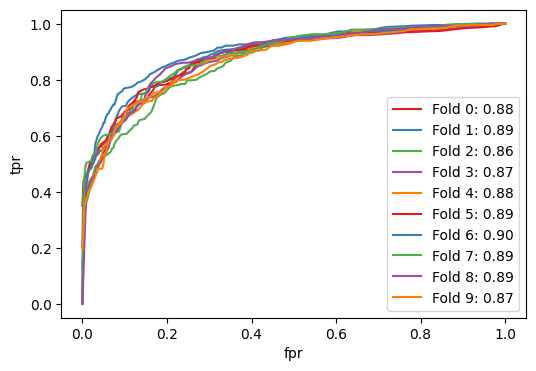

In [159]:
roc_data_arr, auc_score_arr = classify(df_encoded, 'Transported')
plot_roc(roc_data_arr, auc_score_arr)
print('Mean AUC Score: %.2f' % mean_auc_score(auc_score_arr))

Now that we have a beseline, the next set of exepriments are aimed at understanding if we can remove any of the columns. This will help us understand which are the key columns. This will help reduce computation time, memory, etc., but alos help better tune the model based on the important columns.

Remving the below columns does not appear to damage the accuracy of the model.

Mean AUC Score: 0.88


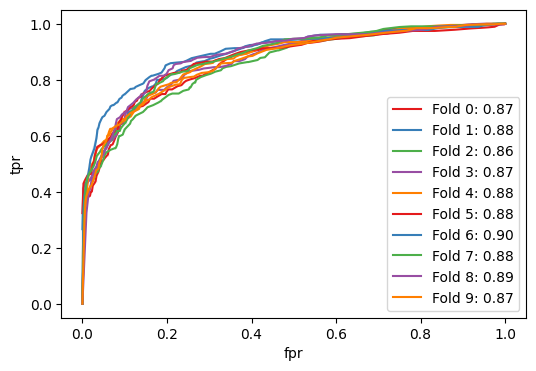

In [163]:
columns_to_drop = ['Passenger_Group', 'Passenger_Group_Number', 'Total_Expenses']
df_encoded_2 = df_encoded.drop(columns=columns_to_drop)

roc_data_arr, auc_score_arr = classify(df_encoded_2, 'Transported')
plot_roc(roc_data_arr, auc_score_arr)
print('Mean AUC Score: %.2f' % mean_auc_score(auc_score_arr))